In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
def activation_relu(Z):
    Z = np.maximum(0, Z)
    return Z

In [3]:
def softmax(Z):
    """每一列为一个实例"""
    #print(Z)
    sum_e = np.sum(np.exp(Z),axis=0)
    #print(sum_e)
    Z = np.exp(Z) / sum_e
    return Z

In [4]:
def zero_pad(X, pad):
    """
    用0填充X的高度和宽度
    X.shape = (m, n_H, n_W, n_C)
    pad为正整数
    X_pad.shape = (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0),(pad,pad),(pad,pad),(0,0)),'constant',constant_values = 0)
    
    return X_pad

In [5]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    # Element-wise product between a_slice and W. Do not add the bias yet.
    s = W * a_slice_prev
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = float(Z + np.reshape(b,(1)))
    ### END CODE HERE ###

    return Z

In [6]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, F, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = F.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev + 2*pad - f) / stride + 1)
    n_W = int((n_W_prev + 2*pad - f) / stride + 1)
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i,:,:,:]                               # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] =  conv_single_step(a_slice_prev, F[:,:,:,c], b[:,:,:,c])
                                        
    ### END CODE HERE ###
    Z = activation_relu(Z)
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, F, b, hparameters)
    
    return Z, cache

In [7]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    ### START CODE HERE ###
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean
                    A[i, h, w, c] = np.max(a_prev_slice)
                    
    
    ### END CODE HERE ###
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [8]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    ### START CODE HERE ###
    # Retrieve information from "cache"
    (A_prev, F, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = F.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros(A_prev.shape)                           
    dF = np.zeros(F.shape)
    db = np.zeros(b.shape)

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i, :, :, :]
        da_prev_pad = dA_prev_pad[i, :, :, :]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += F[:,:,:,c] * dZ[i, h, w, c]
                    dF[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dF, db

In [9]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    ### START CODE HERE ### (≈1 line)
    mask = (np.max(x) == x)
    ### END CODE HERE ###
    
    return mask

In [10]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    
    ### START CODE HERE ###
    
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    f = hparameters['f']
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i,:,:,:]
        
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        
                        # Get the value a from dA (≈1 line)
                        da = np.sum(dA)
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f, f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
                        
    ### END CODE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [11]:
def convert_cifar10_227pix(X,convert_num):
    '''
    将cifar-10数据集的原始矩阵[10000,3072]转化为[10000,227,227,3]
    用于Alexnet训练
    X - 原始矩阵
    convert_num - 将X的前多少张图片数据转化为227*227像素
    '''
    from PIL import Image
    import numpy as np
    X = X[0:convert_num]
#     X = np.reshape(X, (convert_num,3, 32, 32))  # 将图片转换成(m, channel,n_H,n_W)
#     X = X.transpose(0, 2, 3, 1)  # 转换成标准的矩阵(m, n_H,n_W, channel)
    X_resized = np.zeros((convert_num,227,227,3))# 创建一个存储修改过分辨率的矩阵
    
    for i in range(0,convert_num):
        img = X[i]
        img = Image.fromarray(img)
        img = np.array(img.resize((227,227),Image.BICUBIC))# 修改分辨率，再转为array类
        X_resized[i] = img
        
    X_resized /= 255
    return X_resized

In [12]:
def load_file(cifar):
    '''加载cifar数据集'''
    import pickle
    with open('D:\cifar-10-batches-py\\'+str(cifar), 'rb') as fo:
        data = pickle.load(fo, encoding='latin1')
    return data
data = load_file('data_batch_1')
print(data.keys())
X = data['data']
Y = data['labels']
print(X.shape)
print(len(Y))


dict_keys(['batch_label', 'labels', 'data', 'filenames'])
(10000, 3072)
10000


In [13]:
X = np.reshape(X, (10000,3, 32, 32))  # 将图片转换成(m, channel,n_H,n_W)
X = X.transpose(0, 2, 3, 1) 

# img = X[1]
# img = Image.fromarray(img)
# img = np.array(img.resize((227,227),Image.BICUBIC))

X_resized = convert_cifar10_227pix(X,1)
#axarr[1].imshow(X_resized[1])

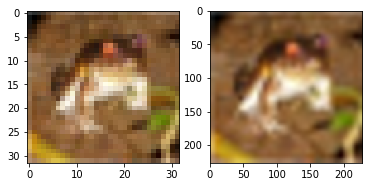

In [14]:
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(X[0])
axarr[1].imshow(X_resized[0])

In [15]:
# 取1张图片出来训练
Y_resized = Y[:1]
Y_resized = tf.one_hot(Y_resized, 10, axis = 0)
sess = tf.Session()
Y_resized = (sess.run(Y_resized)).T
print(X_resized.shape)
print(Y_resized)

(1, 227, 227, 3)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [16]:
def initialize_para(f,prev_channels,next_channels):
    Filter = np.random.randn(f,f,prev_channels,next_channels)
    b = np.zeros((1,1,1,next_channels))
    return Filter,b

In [17]:
def generate_alex_para():
    F1,b1 = initialize_para(11,3,96)
    pool_hpara = {'stride':2, 'f':3}
    F2,b2 = initialize_para(5,96,256)
    #pool_hp_2 = {'stride':2, 'f':3}
    F3,b3 = initialize_para(3,256,384)
    F4,b4 = initialize_para(3,384,384)
    F5,b5 = initialize_para(3,384,256)
    #pool_hp_3 = {'stride':2, 'f':3}
    alex_para = {"F1":F1,"b1":b1,"F2":F2,"b2":b2,"F3":F3,"b3":b3,"F4":F4,"b4":b4,"F5":F5,"b5":b5,"pool_hpara":pool_hpara}
    return alex_para

In [18]:
alex_para = generate_alex_para()

In [20]:
def Alexnet(X, Y, para, learning_rate=0.0006, num_iterations=4001):
    F1 = alex_para["F1"]
    b1 = alex_para["b1"]
    F2 = alex_para["F2"]
    b2 = alex_para["b2"]
    F3 = alex_para["F3"]
    b3 = alex_para["b3"]
    F4 = alex_para["F4"]
    b4 = alex_para["b4"]
    F5 = alex_para["F5"]
    b5 = alex_para["b5"]
    
    pool_hpara = alex_para["pool_hpara"]
    hp_1 = {"stride":4,"pad" : 0}
    hp_2 = {"stride":1,"pad" : 2}
    hp_3 = {"stride":1,"pad" : 1}
    # 1 conv_layer1  
    conv_layer1, conv_cache1 = conv_forward(X, F1, b1, hp_1)
    # 2 max_pool_layer1
    max_pool_layer1, pool_cache1 = pool_forward(conv_layer1, pool_hpara)
    # 3 conv_layer2
    conv_layer2, conv_cache2 = conv_forward(max_pool_layer1, F2, b2, hp_2)
    # 4 max_pool_layer2
    max_pool_layer2, pool_cache2 = pool_forward(conv_layer2, pool_hpara)
    # 5 conv_layer3
    conv_layer3, conv_cache3 = conv_forward(max_pool_layer2, F3, b3, hp_3)
    # 6 conv_layer4
    conv_layer4, conv_cache4 = conv_forward(conv_layer3, F4, b4, hp_3)
    # 7 conv_layer5
    conv_layer5, conv_cache5 = conv_forward(conv_layer4, F5, b5, hp_3)
    # 8 max_pool_layer3
    max_pool_layer3, pool_cache3 = pool_forward(conv_layer5, pool_hpara)
    # FC_layer1
    #flatten = max_pool_layer3.reshape(500,9216)
    flatten = np.array(tf.contrib.layers.flatten(max_pool_layer3)) # shape = (m,9216)
    W1 = np.random.randn(9216,4096)
    FC_layer1 = np.dot(flatten,W1)
    FC_layer1 = activation_relu(FC_layer1)
    # FC_layer2
    W2 = np.random.randn(4096,4096)
    FC_layer2 = np.dot(FC_layer1,W2)
    FC_layer2 = activation_relu(FC_layer2)
    # output_layer
    W3 = np.random.randn(4096,10)
    FC_layer3 = np.dot(FC_layer2,W3)
    FC_layer3 = softmax(FC_layer3)
    print(FC_layer3.shape)

In [ ]:
Alexnet(X_resized, Y_resized, alex_para, learning_rate=0.0006, num_iterations=1)

In [15]:
def save_pix227_cifar10(data):
    import pickle
    
    pix227_cifar10 = 'pix227_cifar10.data'
    data = data
    data_list = [data]
    f = open(pix227_cifar10,'wb')
    pickle.dump(data_list, f)
    f.close()
    del data_list,data

def restore_pix227_cifar10():
    import pickle
    
    f = open('pix227_cifar10.data', 'rb')
    data_list = pickle.load(f)
    data = data_list[0]
    return data

In [ ]:
#save_pix227_cifar10(X_resized)